# ADA Project: Welcome to the final analysis of **Amercian Influence in the Cinema industry**

## Authors
- Group Name: ADACTYLOUS
    - Chloé Bouchiat
    - Claire Pinson
    - Germana Sergi
    - Luca Soravia
    - Marlen Stöckli

## Notebook's structure A MODIFIER POUR P3
- Main librairies and specific functions from the utils folder
- Our analysis workflow with a markdown cell explaining each code cell
- The notebook reads as follow:
    - movie.metadata enriched by IMDB ratings (coming from the IMDb non commercial datasets ([IMDb](https://developer.imdb.com/))
        - General information about the dataset (i.e. basic stats, first visualization)
        - Exploratory analysis of the dataset according to our research questions
    - character.metadata enriched with wikipedia actor's nationality ([DBpedia](https://www.dbpedia.org/about/))
        - General information about the dataset (i.e. basic stats, first visualization)
        - Exploratory analysis of the dataset according to our research questions

#### Recall of the repository structure:
```
📁 ada-2024-project-adactylous
│
├── 📄 results.ipynb (where all ours plots and analysis are)
├── 📄 .gitignore (what is ignored during push and pull requests)
├── 📄 requirements.txt (install into your environment)
├── 📄 README.md
│
├── 📁 data
       │── 📄 actor_metadata_CMU.csv
       │── 📄 movie_metadata_CMU_IMDB.csv
       │── 📄 nationality.csv
       │── 📄 personas_metadata_CMU.csv
       │── 📄 plot_summaries_CMU.csv
├── 📁 src
    ├── 📁 data
    ├── 📁 models
    ├── 📁 scripts
        │── 📄 datasets_cleaner.py
        │── 📄 nationality_importer.py
    ├── 📁 utils
└── 📁 tests
``` 
**NOTE**: Other empty folders and .py files will be filled up later on during the project.

In [1]:
# Import the needed libarairies
import re
import pickle
import warnings # to ignore pandas version warning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.image as mpimg # for image display
import plotly.io as pio # for image display


from matplotlib.ticker import MaxNLocator
from scipy.stats import ttest_ind, spearmanr # to implement statistical tests
from sklearn.metrics import r2_score, accuracy_score
from sklearn.cluster import KMeans # for actors analysis
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, PolynomialFeatures
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle # for balancing train datasets for ordered regression

In [2]:
########################### Read datasets from repository's data folder ############################
movie_mtd = pd.read_table('data/movie_metadata_CMU_IMDB.csv', sep=',')
actor_mtd = pd.read_table('data/actor_metadata_CMU.csv', sep=',')
globes_index = pd.read_csv('data/globes_award_index.csv', sep=',')
# MAYBE DELETE
#personas_mtd = pd.read_table('data/personas_metadata_CMU.csv', sep=',')
plot_summaries_df = pd.read_csv('data/plot_summaries_CMU.csv', sep = ',', usecols= ['ID', 'Summary'])

In [3]:
# Set a global background theme for all our plots and ignore warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

## Movie Success Index 

# Claire

In order to compare the success of movies, one could use the IMDb ratings. However, this metric is not available for all movies and could limit the movies we can compare. Additionally, one could wonder with what parameters the IMDb ratings are corrolated with. 

To answer these questions, a linear regression was fit on movies with available IMDb ratings and some chosen input parameters : the box office revenu (log of the value in USD), the runtime, the languages, the actors, the countries of production, the release year and the CMU genres. Any NaN for these variables would remove the movie from the dataset. To be representative of the population of movies, this dataset was also containing the same percentage of partially US movies / only US movies and rest-of-the-world movies, leading to ~550 movies in total. 

During the pre-processing, a Multilabel binarizer is implemented. It acts similarly to the 'get dummies', but allows a given movie to have several labels. The function was applied on the attributes of the countries, the actors, the genres and the languages. In addition, to avoid overfitting of the model, the created labels there were not appearing often (=1 less than 10 times -3 times for actors-) were discarded. 

The linear model was fit on 80% of the dataset and evaluated on a test set. The results show that the model is explaining 42% of the variance on the train set and test set. However, the R^2 reached 47% when 5-fold cross validation was implemented. **These results show that the model is capturing some trend of the IMDb ratings, but is not accurate enough to be considered a modelling of the ratings.** Therefore, the predictions are used for the creation of the Movie Success Index (MSI), an index different from the IMDb ratings but which is still a metric of success. 

By printing the weights of the linear regression, one observes that genres and languages seem to be the most correlated parameters to a movie's success. Especially, drama movies are in general appreciated, which is consistent with our results from Milestone P2 : the US where exporting lots of drama movies, so the rest of the world is likely enjoying this genre. The weights generated for the binarized labels are easy to compare, since being positive to one of them means that the predicted value of the movie is being increased by the same value as the corresponding weight, but it is not the case with the continuous features. Indeed, the ratings being bounded between 0 and 10, the weights of the runtime feature in minutes (which is around 80 minutes for most movies) are way smaller. This difference in the magnitude of the values of the features (0/1 or ~ 80) does not allow the comparison of the weights.

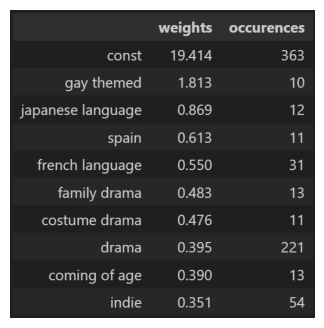

In [4]:
########################## Show TOP weights of the linear regression ##########################

# Load the figure
img = mpimg.imread('data/plots_website/screenshot_weights_MSI.png')

plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.axis('off')  # remove automatic axis
plt.show()

After evaluating the performance of the model with a dataset containing the IMDb ratings, the predictions was carried out with an extended dataset. This dataset still contains all the features needed for prediction with no NaN values, but does not necessarly contain the IMDb ratings. This entended dataset contains ~ 8 000 movies, which is way higher than the dataset used for training. 

The predictions of this dataset are bounded between 4.36 and 9.77 (range = 9.77-4.36), i.e. there is not value outside of the IMDb range [0;10]. This absence of outliers makes the post-processing easier. However, the predictions are still ranged within the central 95% of that interval when converted to the MSI. For instance, a movie having a prediction smaller than (4.36 + range x 0.025) will be assigned a MSI of 0. The predictions within the central 95% of the range are simply rescaled between 0 (corresponding to 4.36 + range x 0.025) and 100 (corresponding to 4.36 - range x 0.025). 

The final MSI in therefore bounded between 0 and 100, with outliers and values at the border assigned to 0 or 100. 

If that could seem weird the the mean IMDb is around 6 but the mean MSI is around 35, let's keep in mind that the MSI is a metric of success meant to be used for comparison and is not meant to be interpreted alone.

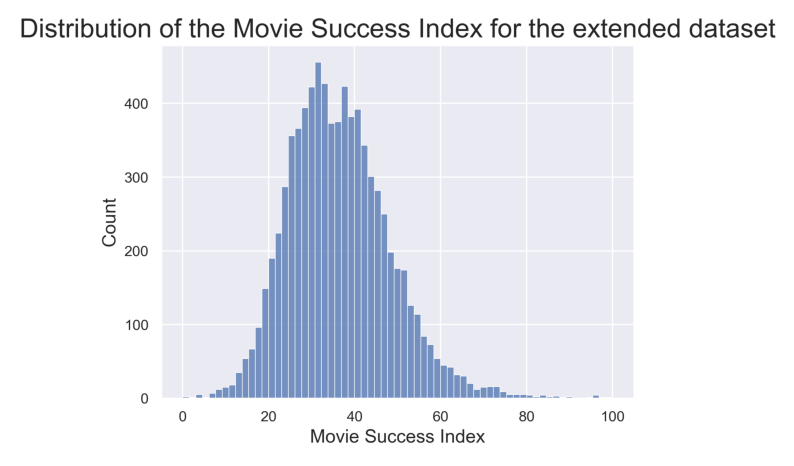

In [5]:
########################## Show MSI distribution ##########################

# Load the plot saved in another script
img = mpimg.imread('data/plots_website/MSI_distribution.png')

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  # remove automatic axis
plt.show()

Now, going back to our research questions, are US movies more successful than other movies ?

The boxplots of MSI are shown below for movies produced by the US (partially or totally) and other movies :

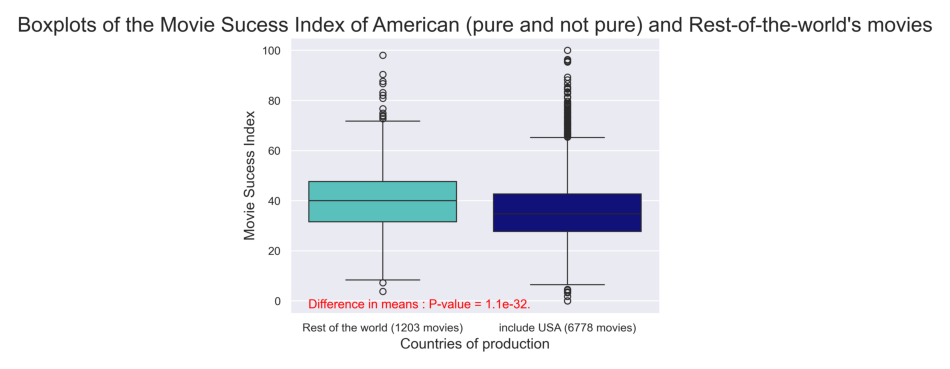

In [7]:
########################## Show MSI distribution ##########################

# Load the plot saved in another script
img = mpimg.imread('data/plots_website/MSI_boxplot.png')

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')  # remove automatic axis
plt.show()


Surprisingly, the US movies are significantly a bit less successfull than movies not produced by the US. As seen before, US are producing nearly half of the movies worldwide, they probablly produced lots of 'bad movies' among a few master pieces, but draws to mean towards lower values.

Note : the boxplots show normal distributions of the MSI, it is therefore possible to use the t-test to determine if the means are the same.

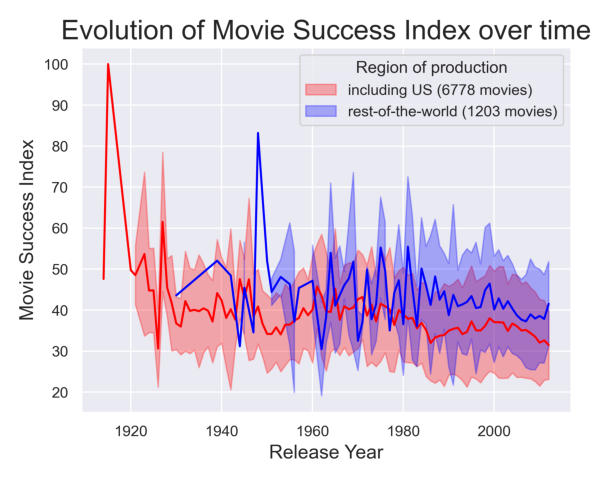

In [25]:
########################## Show MSI timeline ##########################

# Load the plot saved in another script
img = mpimg.imread('data/plots_website/MSI_timeseries.png')

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # remove automatic axis
plt.show()

One observes that since the 80s, there is a clear trend that the movies not produced by the US have a better Success index. Moreover, the MSI of US movies seems to decrease slightly over time, from ~40 in the beginning of the 20th century to an average of 35 recently. The comparaison between the two regions is not possible in the firest half of the 20th century as too few movies from the rest-of-the-world are in the dataset. 

However, this timeline has some limitations. Indeed, the translations taken in account are not necessarly produced the same year that the movie is released, and can improve the success of a movie as time goes on, same for the box office revenue. The success is therefore not ponctually only the year of the release but can influence generations. For instance, some master pieces like 'Star Wars: Episode VI – Return of the Jedi' released in 1983 is still a classic of the saga and still appreciated, even though it is only represented by a datapoint in the year 1983 on the above timeseries.


## Actor Success Index

#### Explanation of the process
After having created a Movie Success Index, the process will create a similiar success index for actors. To do so, the dataset is enriched with the following procedure: A dataset of all nominations for Golden Globes from 1944 to 2020 ([Kaggle, Golden Globes](https://www.kaggle.com/datasets/unanimad/golden-globe-awards)). This dataset contains for every nomination ever one datapoint and the information, if the nominee won or not, besides other features. In the *dataset_cleaner.py*, the number of nominations and wins per actor were counted. From this infomration, an index for Golden Globes nominations was created and saved as a dataframe opened above (see src\scripts\create_award_index.py). Using this Golden Globe index as target variable, an ordered regression model is built to measure the success of an actor. 

**Disclaimer**: One implements here rather low-level computations which are needed to show, how the model performs. This allows to better interpret the results in a critical manner.

The cells bellow guide through the creation process of the success index for actors.

In [120]:
# Match the index with the data
globes_index = globes_index.rename(columns={"nominee":"actor_name"})

#### Create useful features for the creation of the success index

In [121]:
df_actors = actor_mtd[['actor_name', 'birth_date', 'gender', 'height', 'nationality']].drop_duplicates(subset='actor_name').reset_index()

# Age
min_age = actor_mtd.groupby('actor_name', as_index=False)['age_at_release'].min()
min_age.rename(columns={'age_at_release': 'age_first_movie'}, inplace=True)
df_actors = df_actors.merge(min_age, on='actor_name', how='left')

max_age = actor_mtd.groupby('actor_name', as_index=False)['age_at_release'].max()
max_age.rename(columns={'age_at_release': 'age_last_movie'}, inplace=True)
df_actors = df_actors.merge(max_age, on='actor_name', how='left')

# Number of movies
count_movies = actor_mtd.groupby('actor_name', as_index=False)['title'].count()
count_movies.rename(columns={'title' : 'number_of_movies'}, inplace=True)
df_actors = df_actors.merge(count_movies, on='actor_name', how='left')

# Career length
df_actors['career_length'] = df_actors['age_last_movie'] - df_actors['age_first_movie']

In [122]:
# Famous movies

# Names of famous movies (top 10% based on box_office)
famous_movie_df = movie_mtd.sort_values('box_office', ascending = False)
len_revenue = int(len(famous_movie_df) * 0.1)
top_10_percent_movies = famous_movie_df.head(len_revenue)
names_fam_movies = top_10_percent_movies['title'].to_list()

# Count famous movies per actor
df_famous = actor_mtd[actor_mtd['title'].isin(names_fam_movies)]
actor_famous_count = df_famous.groupby('actor_name')['title'].nunique().reset_index()

# Merge the information with the original dataframe
all_actors = pd.DataFrame({'actor_name': actor_mtd['actor_name'].unique()})
actor_famous_count_full = pd.merge(all_actors, actor_famous_count, on='actor_name', how='left')
actor_famous_count_full['title'] = actor_famous_count_full['title'].fillna(0).astype(int)
df_actors['numb_fam_movies'] = actor_famous_count_full['title']

#### Prepare data for the model: Golden globes ground truth

In [123]:
# Merge the golden globe - based index

df_actors_merged = df_actors.merge(globes_index, on = 'actor_name', how = 'left')
# We suppose that the actors that are not in the globes_index dataframe have 0 nominees/awards
df_actors_merged = df_actors_merged.fillna(0) 

df_actors_merged.head()

,index,actor_name,birth_date,gender,height,nationality,age_first_movie,age_last_movie,number_of_movies,career_length,numb_fam_movies,nr_wins,nr_nominations,globes_index
0,0,Wanda De Jesus,1958.0,F,1.620,American,31.0,51.0,8.0,20.0,5,0.0,0.0,0.0
1,1,Natasha Henstridge,1974.0,F,1.780,Other,20.0,35.0,23.0,15.0,7,0.0,0.0,0.0
2,2,Ice Cube,1969.0,M,1.727,American,22.0,42.0,33.0,20.0,20,0.0,0.0,0.0
3,3,Jason Statham,1967.0,M,1.750,Other,30.0,44.0,31.0,14.0,26,0.0,0.0,0.0
4,4,Clea DuVall,1977.0,F,1.650,American,19.0,34.0,31.0,15.0,15,0.0,0.0,0.0


At this point it is highlighted, that the dataset is strongly imbalanced because just the very good actors are nominated for Golden Globes which corresponds to a small portion compared to the whole actor dataset. Therefore, many actors have a Golden Globe index of 0.

In [124]:
# Prepare data for the regression

# The following features are considered important to train the model:
features = ['gender','height','age_first_movie','number_of_movies','career_length','numb_fam_movies']

X = df_actors_merged[features]
X = pd.get_dummies(X)
X = X.drop(columns=['gender_0']) # to avoid redundacy (std err, z, P>|z| were all nan)
Y = df_actors_merged['globes_index'] # target variable

In [125]:
# Split to test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle = True)

# Standardize data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Convert to DataFrame with aligned indices
X_train = pd.DataFrame(X_train_std, columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_std, columns=X.columns, index=X_test.index)

# Displaying the size of each sets
print(f"The training set has {X_train.shape[0]} samples (and a shape of {X_train.shape}).")
print(f"The test set has {X_test.shape[0]} samples (and a shape of {X_test.shape}).")

print(f"The target variable y for training has the shape {y_train.shape}.")
print(f"The target variable y for testing has the shape {y_test.shape}.")

The training set has 107263 samples (and a shape of (107263, 7)).
The test set has 26816 samples (and a shape of (26816, 7)).
The target variable y for training has the shape (107263,).
The target variable y for testing has the shape (26816,).


#### Balancing the datasets

In [126]:
# Undersampling to balance the dataset

# Combine the training data into a DataFrame
df_train = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
df_majority = df_train[df_train['globes_index'] == 0.0]
df_minority = df_train[df_train['globes_index'] != 0.0]

# Oversample the minority class
df_minority_oversampled = df_minority.sample(len(df_majority), replace=True, random_state=42)

# Combine the majority and oversampled minority classes
df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Separate features and target
X_train = df_balanced.drop('globes_index', axis=1)
y_train = df_balanced['globes_index']

# Shuffle the dataset to ensure random distribution
X_train, y_train = shuffle(X_train, y_train, random_state=42)

#### Ordered regression

In [127]:
# The used indices are ordered (0<1<2<3)

model = OrderedModel(y_train, X_train, distr='logit')  # The model automatically adds a constant
result = model.fit()  # Provide appropriate weights for each class
print(result.summary())

                             OrderedModel Results                             
Dep. Variable:           globes_index   Log-Likelihood:            -2.0084e+05
Model:                   OrderedModel   AIC:                         4.017e+05
Method:            Maximum Likelihood   BIC:                         4.018e+05
Date:                Wed, 18 Dec 2024                                         
Time:                        19:00:53                                         
No. Observations:              211920                                         
Df Residuals:                  211910                                         
Df Model:                           7                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
height               0.1636      0.004     44.340      0.000       0.156       0.171
age_first_movie     -0.0276      0

An ordered regression has been implemented for this model, because the number of nominations and wins for a Golden Globes Award was translated to an ordered award index with the following definition (in the *data_cleaner.py*): 
-    0 points if never nominated, 
-    1 point if at least once nominated
-    2 points if at least once won
-    3 points if more than once won

Looking at the results of the model on the training set, one observes, that height and the number of movies acted in are the most important coefficients of this regression model. All the coefficients have a p-value below 0.05 what makes them statistically significant.

In [128]:
# Predict on test data
y_pred_probs = result.predict(X_test)
y_pred = y_pred_probs.idxmax(axis=1)  # Take the category with the highest probability

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Data: {accuracy:.4f}')

Accuracy on Test Data: 0.8525


The accuracy of the model was around 93% before the downsampling, indicating a tendency of the model to predict the umbalanced class (class 0), making few errors on the other, less relevant, classes. After balancing the dataset, the accuracy decreased to 85.25%, which is still an acceptable metric, indicating a quite accurate model. Therefore, the created success index based on the Golden Globes Awards seems to be robust.

In [129]:
# The dataset is imbalanced

print(f'Train set: {y_train.value_counts()}')
print(f'Test set: {y_test.value_counts()}')

Train set: globes_index
0.0    105960
1.0     61899
2.0     31898
3.0     12163
Name: count, dtype: int64
Test set: globes_index
0.0    26480
1.0      206
2.0       97
3.0       33
Name: count, dtype: int64


Once again, we see that most of the actors have never been nominated for a Golden Globe Award.

#### Inference

In [130]:
# Predict on all data

X_new = df_actors[features]

# Pre process in the same way
X_new = pd.get_dummies(X_new)
X_new_std = scaler.transform(X_new)
X_new = pd.DataFrame(X_new_std, columns=X_new.columns, index=X_new.index)
y_pred_probs_new = result.predict(X_new)
y_pred_new = y_pred_probs_new.idxmax(axis=1)

In [131]:
# Add the predictions to the dataframe
df_actors['predicted'] = y_pred_new

# See the average index for American vs. Foreign actors
avg_index = df_actors.groupby('nationality')['predicted'].mean()
print(f'The average success indices are: \n{avg_index}')

The average success indices are: 
nationality
American    1.082310
Other       1.046512
Name: predicted, dtype: float64


Interestingly, nearly no difference between American actors and foreign actors can be detected in the predicted average success index.

In [132]:
# Print descriptive statistics
stats = df_actors.groupby('nationality')['predicted'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
nationality,,,,,,,,
American,6512.0,1.082310,0.333434,0.0,1.0,1.0,1.0,3.0
Other,3483.0,1.046512,0.268200,0.0,1.0,1.0,1.0,3.0


#### Visualizations

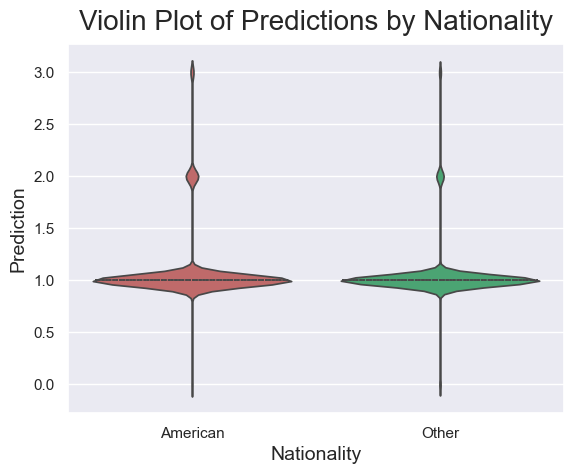

In [133]:
sns.violinplot(x='nationality', y='predicted', data=df_actors, palette = {'American': 'indianred', 'Other': 'mediumseagreen'}, scale='count', inner="quart")

plt.xlabel("Nationality", fontsize=14)
plt.ylabel("Prediction", fontsize=14)
plt.title("Violin Plot of Predictions by Nationality", fontsize = 20, pad =10)
plt.savefig('data/plots_website/actors_violin_plot_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

A violin plot is used to have insights on the internal distribution of the predictions. One notices that, for both groups, the predictions are densely concentrated in the class 1. However,the Americans seem to have more predictions also for classes 2 and 3, while for the foreigners the class 0 is slightly denser. These small differences determine the higher average index obtained by the Americans.

## NLP Analysis on plot summaries


#### Basic statistics and preliminary analysis 

Subdataset creation to facilitate the analysis

In [135]:
# Creating deep copies of the original data frame to avoid messing it up
all_movies = movie_mtd.copy() # all movies in the dataset, no matter their production country
us_movies = movie_mtd.copy() 
us_partially_movies = movie_mtd.copy()
all_us_movies = movie_mtd.copy()
rest_world_non_US = movie_mtd.copy()

## Filtering the newly created dataframes for the analysis of box office revenues, IMDb ratings and runtimes
# Movies strictly produced in the US
us_movies = us_movies[us_movies['countries'] == 'United States of America']
# Movies partially produced in the US
us_partially_movies = us_partially_movies[(us_partially_movies['countries'].str.contains('United States of America') == True) & (us_partially_movies['countries'] != 'United States of America')]
# Contains the movies strictly produced in the US and the ones partially produced in the US
all_us_movies = all_us_movies[(all_us_movies['countries'] == 'United States of America') | (all_us_movies['countries'].str.contains('United States of America') == True)]

# Non-US movies
rest_world_non_US = rest_world_non_US[(rest_world_non_US['countries'].str.contains('United States of America') == False) & (rest_world_non_US['countries'] != 'United States of America')]

Opening of the plot summaries dataset

In [136]:
# Increase the display width to see more characters per column
pd.set_option('display.max_colwidth', None)  # this removes the column width limit

plot_summaries_df['Plot Summary Preview'] = plot_summaries_df['Summary'].apply(
    lambda x: ' '.join(re.split(r'(?<=[.!?])\s+', x)[:4]) # the re pattern checks if the sentence ends with ".!?" and the '.join' rebuilds the string after the split
)

# Sort the plot summaries according to the Wikipedia movie ID
plot_summaries_df_sorted = plot_summaries_df.sort_values(ascending = True , by= 'ID')

print(f"The size of the plot summaries dataset is {plot_summaries_df.shape}.")

# Show the first 4 sentences in the Preview column
plot_summaries_df[['ID', 'Plot Summary Preview']].head()

The size of the plot summaries dataset is (42303, 3).


,ID,Plot Summary Preview
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had earlier given jail sentence to Manapally in a corruption case. Induchoodan, who had achieved top rank in Indian Civil Service loses the post and Manapally Sudheeran ([[Saikumar enters the list of civil service trainees. We learn in flashback that it was Ramakrishnan the son of Moopil Nair , who had actually killed his classmate."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfortunately for the Kid, the woman ""belongs"" to notorious gangster Moose Moran , as does the money."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy returns to the tent to check on Azaria and is certain she sees a dingo with something in its mouth running off as she approaches. When she discovers the infant is missing, everyone joins forces to search for her, without success."


Merging the plot summaries dataset with the movie_mtd dataset in order to distinguish between US-only, partially US and non US produced (= ROW) movies

In [137]:
# Performing inner joins to be sure each movie kept after the merge has a plot summaries and filtering to keep only useful columnbs for the rest of the analysis
# ID column is not useful anymore so one can remove it
plot_summaries_all_movies = pd.merge(plot_summaries_df, all_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title', 'Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_us_movies = pd.merge(plot_summaries_df, us_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title','Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_us_partially_movies = pd.merge(plot_summaries_df, us_partially_movies, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title', 'Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

plot_summaries_RoW_movies = pd.merge(plot_summaries_df, rest_world_non_US, left_on= 'ID', right_on= 'wiki_movie_ID', how = 'inner').filter(items=['title','Summary', 'box_office', 'language', 'genres_IMDB', 'release_year', 'averageRating', 'numVotes'], axis = 1)

print(f"The size of the plot summaries dataframe merged with the dataset containing all the movies metadata is {plot_summaries_all_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing US-only produced movies is {plot_summaries_us_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing all the partially US-produced movies is {plot_summaries_us_partially_movies.shape}.")
print(f"The size of the plot summaries dataframe merged with the dataset containing all Non US-produced movies is {plot_summaries_RoW_movies.shape}.")

The size of the plot summaries dataframe merged with the dataset containing all the movies metadata is (42208, 7).
The size of the plot summaries dataframe merged with the dataset containing US-only produced movies is (17776, 7).
The size of the plot summaries dataframe merged with the dataset containing all the partially US-produced movies is (3015, 7).
The size of the plot summaries dataframe merged with the dataset containing all Non US-produced movies is (18105, 7).


Counting the number of plot summaries according to a given word range

In [138]:
def plot_counter(df, lower_bound=1, upper_bound=20): # setting default lower and upper bounds value
    """
    Function that counts the number of plot summaries containing a given number of words.

    Params:
        df (pd.DataFrame): DataFrame containing a column 'Summary'.
        lower_bound (int, optional): Minimum number of words in a plot summary (exclusive).
                                     Use None to apply no lower bound. Default is 1.
        upper_bound (int, optional): Maximum number of words in a plot summary (inclusive).
                                     Default is 20.
    Returns: The count of summaries within the specified word count range (int).
    """
    if 'Summary' not in df.columns:
        raise ValueError("The dataframe must have a column named 'Summary'.")

    # Compute plots counts once for efficiency
    plots_counts = df['Summary'].apply(lambda x: len(str(x).split())) # split words based on white spaces

    if lower_bound is None:
        # Apply only the upper bound
        return plots_counts[plots_counts >= upper_bound].count()
    else:
        # Apply both lower and upper bounds
        return plots_counts[(plots_counts > lower_bound) & (plots_counts <= upper_bound)].count()

# Initializing the need lists and dictionnary
list_name_df = ['All movies', 'US-only produced movies', 'Partially US-produced movies', 'Non US-produced movies']
list_df_plot_summaries = [plot_summaries_all_movies, plot_summaries_us_movies, plot_summaries_us_partially_movies, plot_summaries_RoW_movies]
list_set_number_words = [[1, 20], [20, 100], [100, 300], [300,500], [500, 1000], [1000, 2000], [2000, 3000]] # ranges of numbers of words in order to count the number of plots summaries falling in that range
dict_plot_count = {'All movies': [], 'US-only produced movies': [], 
                   'Partially US-produced movies': [], 'Non US-produced movies': [], 
                   }

# Use of "zip" will make the loop terminates when the shortest iterable is exhausted so one put it in the second for loop to make sure all the 7 words count interval are processed
dict_plot_count = {name: [] for name in list_name_df}
interval_names = [f"{low}-{high}" for low, high in list_set_number_words]

for interval in list_set_number_words:
    for df, dico_name in zip(list_df_plot_summaries, list_name_df):
        word_count = plot_counter(df, lower_bound = interval[0], upper_bound = interval[1])
        dict_plot_count[dico_name].append(word_count)

# Create DataFrame with interval names as index and title
df_count_plot_summaries = pd.DataFrame(dict_plot_count, index=interval_names)

# Add a title for the rows as an index
df_count_plot_summaries.index.name = "Word number Interval"

# Compute the total number of plot summaries for each columns and add it as the last row of the df
df_count_plot_summaries.loc["Total"] = df_count_plot_summaries.sum(axis=0)

print("The below table shows the number of plot summaries satisfying the number of word range (rows of the displayed dataframe)")
df_count_plot_summaries.head(8)

The below table shows the number of plot summaries satisfying the number of word range (rows of the displayed dataframe)


,All movies,US-only produced movies,Partially US-produced movies,Non US-produced movies
Word number Interval,,,,
1-20,397,133,11,180
20-100,12137,4639,531,5662
100-300,14406,5600,702,6905
300-500,5933,2745,450,2392
500-1000,7867,3973,1073,2501
1000-2000,1381,658,235,428
2000-3000,69,25,10,29
Total,42190,17773,3012,18097


One notices first that most of the plot summaries show a number of words between 100 and 300. Next, come the plots having 20-100 words intheir summaries. One sees that they are very few plots summaries with more than 2000 words. Finally, one sees that with those word intervals one captures nearly all the movies. Indeed, th column *total* for all the movies shows 42190 movies out of 42208 (see above cell) meaning that only 18 plots summarie shave more than 3000 words. One observe similar behavior for the US-only produced, Partially US-produced and Non Us-produced movies.

Visualization of the results

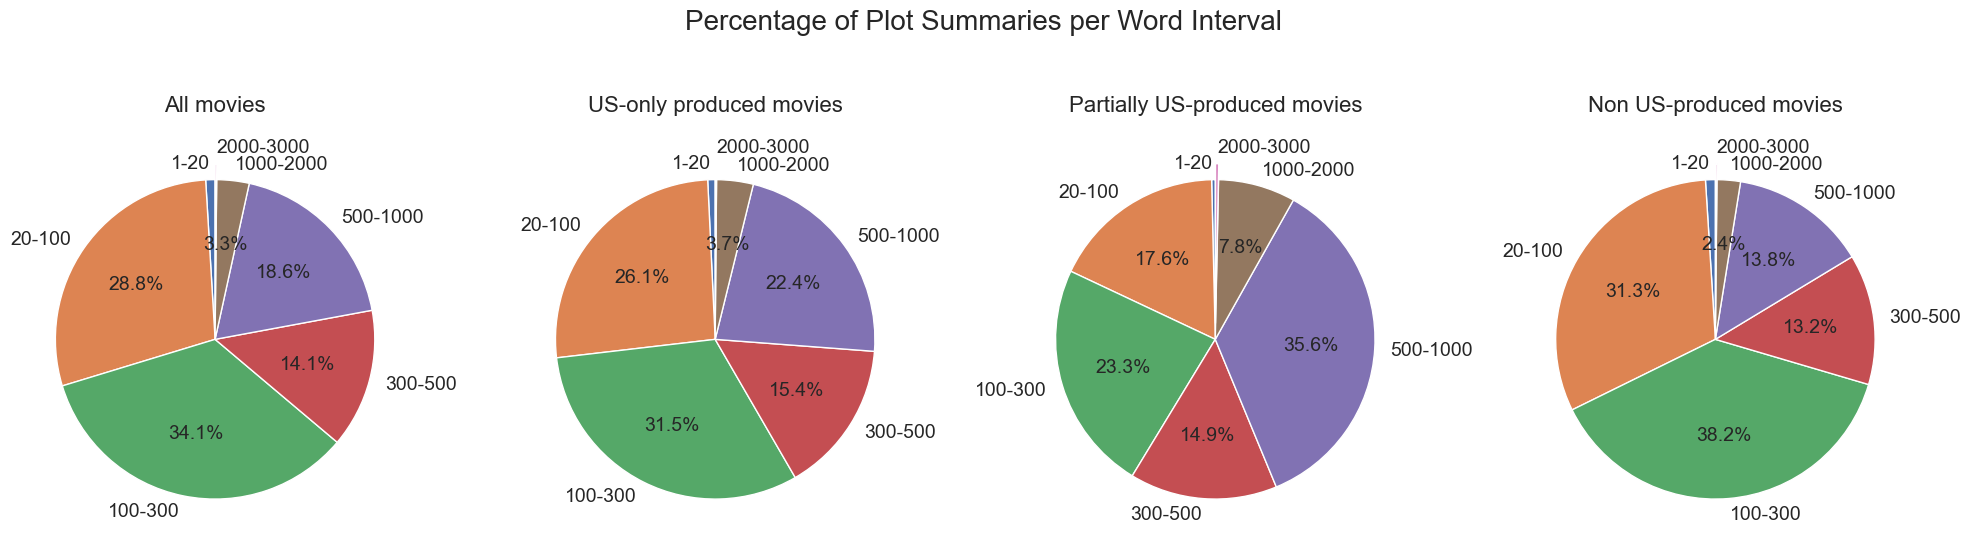

In [139]:
colors = sns.color_palette("pastel", len(df_count_plot_summaries.index))

def autopct_threshold(pct):
    return f'{pct:.1f}%' if pct > 1 else ''  # Only display if percentage > 1%

plots = df_count_plot_summaries.iloc[:-1].plot.pie(
    subplots=True,
    figsize=(20, 8),
    title= False,
    legend=False,
    autopct=autopct_threshold,
    explode=(0, 0, 0, 0, 0, 0, 0.1),
    shadow=False,
    startangle=90,
    textprops={'fontsize': 14},
    color = colors
)

# Manually set the titles above the charts
titles = df_count_plot_summaries.columns
for ax, title in zip(plots, titles):
    ax.set_title(title, fontsize=16, y=1.05)  # Adjust y to move title above
    ax.set_ylabel('')  # Remove the default title on the left

# Global adjustments
plt.suptitle("Percentage of Plot Summaries per Word Interval", fontsize=20)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])
plt.savefig('data/plots_website/summaries_word_interval.png', dpi=300, bbox_inches='tight')
plt.show()

## NLP on plot summaries

### A) Assessing the american culture in plots summaries using GPE (i.e. location only)
One recalls that GPE stands for *Geopolitical entity, i.e. countries, cities, states* ([see here](https://spacy.io/usage/linguistic-features/)). The aim is here to assess the "percentage" of amercian culture in each plot summaries by only looking at the locations present in the plot. Indeed, if the plot summary, i.e. the summary of the story told by the movie, contains some amercian cities or states name(s), it "represents" in a way the amercian culture since the movie director chose the US as a location to tell his story (or part of his story in other locations are present).

For this first part, one does not use a set containing all cities, counties and states in the US but rather the python library *GeoPy* that allows to return the most probable location among all possible ones worldwide ([Geopy nominatim](https://geopy.readthedocs.io/en/stable/#nominatim)). For example, the city of *London* exists both in the UK and in the US, in Ohio ([London, Ohio, USA](https://en.wikipedia.org/wiki/London,_Ohio)). The only downside of this approach comes from the requests the code must perfomr to the *Geopy* API. This slows down the computations a bit since one must pause the program to avoid the server to block the request. To partially solve this issue, one implements caching: a caching dictionary stores every scanned locations by the *Nominatim* function to avoid requesting the same locations many time during the processing.

Although this approach is slower than just reading a CSV file containing all US cities, counties and states and creating a Python set, it has the big advantage of not counting famous cities as London or Edinburgh as being part of the US. Indeed, many US cities are named from famous cities worldwide. For example the city of Edinburgh located in Scotland, also exists in the US ([Edinburgh, Indiana, USA](https://en.wikipedia.org/wiki/Edinburgh,_Indiana )). To conclude the use of the *Geopy* library and API allows to obtain robust results to assess the precentage of american culture by looking only at locations in the plot summaries.

### Visualization of the results

#### 1) Processing the US-only produced movies

In [140]:
# Visualization of the result:
df_GPE_us_only = pd.read_csv("data/NLP_datasets/us_only_movies_NLP_GPE.csv", sep=',')

# Percentages of american culture using GPE
mean_american_culture_GPE_us_only_movies = df_GPE_us_only['Percentage_american_culture'].mean()*100

# count the proportions of zeros
df_GPE_us_only['Percentage_american_culture'] = pd.to_numeric(df_GPE_us_only['Percentage_american_culture']).astype('float64')
proportion_0_percenatge_us = (len(df_GPE_us_only[df_GPE_us_only['Percentage_american_culture'] == 0.0])/len(df_GPE_us_only))*100

print(f"The mean american culture percentage for US-only produced movies using only GPE information is {mean_american_culture_GPE_us_only_movies:.2f} %.")
print(f"The percentage of zero values on the US-only GPE dataset is: {proportion_0_percenatge_us:.2f} %.")
print(f"Shape verification of the US-only GPE dataset: shape: {df_GPE_us_only.shape}")

df_GPE_us_only.head(10)

The mean american culture percentage for US-only produced movies using only GPE information is 36.72 %.
The percentage of zero values on the US-only GPE dataset is: 57.02 %.
Shape verification of the US-only GPE dataset: shape: (17776, 9)


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_US_frequencies,Percentage_american_culture
0,The Hunger Games,686533290.0,"Action,Adventure,Sci-Fi",2012.0,7.2,1022897.0,['Panem'],Counter(),0.000000
1,The Lemon Drop Kid,2300000.0,"Comedy,Crime,Music",1951.0,7.0,2303.0,"['New York City', 'Florida', 'New York', 'New York', 'Manhattan', 'Nyack', 'Nellie']","Counter({'New York': 2, 'New York City': 1, 'Florida': 1, 'Manhattan': 1, 'Nyack': 1, 'Nellie': 1})",1.000000
2,Dark Water,49483352.0,"Drama,Horror,Mystery",2005.0,5.6,66164.0,"['Jersey City', 'Roosevelt Island', 'Jersey City']","Counter({'Jersey City': 2, 'Roosevelt Island': 1})",1.000000
3,Sing,2260616.0,"Drama,Musical",1989.0,6.7,974.0,['Brooklyn'],Counter({'Brooklyn': 1}),1.000000
4,Meet John Doe,NaN,"Comedy,Drama,Romance",1941.0,7.6,15255.0,['Millsville'],Counter(),0.000000
5,Husband for Hire,NaN,NaN,2008.0,NaN,NaN,"['Texas', 'New Mexico']","Counter({'Texas': 1, 'New Mexico': 1})",1.000000
6,Exodus,NaN,NaN,1960.0,NaN,NaN,"['Israel', 'Cyprus', 'Palestine', 'Mandate Palestine', 'Famagusta', 'America', 'Palestine', 'Jerusalem', 'Abu Yesha', 'Gan Dafna', 'Israel', 'Jerusalem', 'Gan Dafna', 'Gan Dafna']","Counter({'Palestine': 2, 'America': 1})",0.214286
7,House Party 2,19438638.0,"Comedy,Drama,Music",1991.0,5.3,7205.0,[],Counter(),0.000000
8,Charlie Chan's Secret,NaN,NaN,1936.0,NaN,NaN,[],Counter(),0.000000
9,The Biggest Fan,NaN,NaN,2002.0,NaN,NaN,[],Counter(),0.000000


At first sight on the dataframe above, the results look again robust. Now, the algorithm recognized correctly "Roosvelt Island" as a geographic location in the US ([Roosvelt Island, NY USA](https://en.wikipedia.org/wiki/Roosevelt_Island)). However, "Palestine" was this time recognized as a city in Texas ([Palestine, Texas USA](https://en.wikipedia.org/wiki/Palestine,_Texas)) altough the plot of the concerned movie *Exodus* only refers to Palestine in the context of the Middle East ([Exodus Movie](https://en.wikipedia.org/wiki/Exodus_(1960_film))). 

#### 2) Processing the partially US-produced movies

In [141]:
df_GPE_partially_us = pd.read_csv("data/NLP_datasets/us_partially_movies_NLP_GPE.csv", sep=',')


mean_american_culture_GPE_partially_us_movies = df_GPE_partially_us['Percentage_american_culture'].mean()*100

# count the proportions of zeros
df_GPE_partially_us['Percentage_american_culture'] = pd.to_numeric(df_GPE_partially_us['Percentage_american_culture']).astype('float64')
proportion_0_percenatge_us_partially = (len(df_GPE_partially_us[df_GPE_partially_us['Percentage_american_culture'] == 0.0])/len(df_GPE_partially_us))*100

print(f"The mean american culture percentage for partially US-produced movies using only GPE information is {mean_american_culture_GPE_partially_us_movies:.2f} %.")
print(f"The percentage of zero values on the partially US GPE dataset is: {proportion_0_percenatge_us_partially:.2f} %.")
print(f"Shape verification of the US-only GPE dataset: shape: {df_GPE_partially_us .shape}")

df_GPE_partially_us.head(10)

The mean american culture percentage for partially US-produced movies using only GPE information is 27.61 %.
The percentage of zero values on the partially US GPE dataset is: 60.17 %.
Shape verification of the US-only GPE dataset: shape: (3015, 9)


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_US_frequencies,Percentage_american_culture
0,A Cry in the Dark,6908797.0,NaN,1988.0,NaN,NaN,"['Azaria', 'Uluru']",Counter(),0.00
1,End Game,NaN,"Action,Thriller",2006.0,5.1,5745.0,[],Counter(),0.00
2,"Come Back, Africa",NaN,NaN,1960.0,NaN,NaN,"['Johannesburg', 'Sophiatown']",Counter(),0.00
3,Kehtaa Hai Dil Baar Baar,NaN,"Comedy,Drama,Romance",2002.0,4.7,204.0,"['India', 'New York']",Counter({'New York': 1}),0.50
4,Pieces,2032311.0,NaN,1982.0,NaN,NaN,['Boston'],Counter({'Boston': 1}),1.00
5,The Good Life,NaN,"Comedy,Drama",2007.0,6.4,2352.0,['Nebraska'],Counter({'Nebraska': 1}),1.00
6,Eastern Promises,17266000.0,NaN,2007.0,NaN,NaN,"['London', 'UK', 'London', 'Edinburgh']",Counter(),0.00
7,"Wait Until Spring, Bandini",NaN,Drama,1989.0,6.2,754.0,['Colorado'],Counter({'Colorado': 1}),1.00
8,Sophie's Choice,30036000.0,"Drama,Romance",1982.0,7.5,53987.0,"['Brooklyn', 'U.S.', 'Brooklyn', 'Virginia']","Counter({'Brooklyn': 2, 'Virginia': 1})",0.75
9,Until Death,NaN,"Action,Crime,Drama",2007.0,5.7,10503.0,"['New Orleans', 'New Orleans']",Counter({'New Orleans': 2}),1.00


First one notices that the *Geopy* library gives some robust results. Indeed, one immediately sees that London and Edinburgh are not counted as US locations because the probability is much higher that the plot summary talks about London UK than about London, Ohio, US. Moreover, for the movie *Come Back, Africa* that takes place in South Africa ([see here](https://en.wikipedia.org/wiki/Come_Back,_Africa)), one notices that the city of Johannesburg is not treated as being part of the State of California which is the desired output ([Johannesburg, California, USA](https://en.wikipedia.org/wiki/Come_Back,_Africa)). The US states such as Nebraska and Colorado are also perfectly recognised. One analyses the percentage of American culture in the plot, 5 cells below.

#### 3) Processing the partially Non-US (RoW) produced movies

In [142]:
df_GPE_RoW = pd.read_csv("data/NLP_datasets/Row_movies_NLP_GPE.csv", sep=',') 

# Percentages of american culture using GPE
mean_american_culture_GPE_RoW_movies = df_GPE_RoW['Percentage_american_culture'].mean()*100

# count the proportions of zeros
df_GPE_RoW['Percentage_american_culture'] = pd.to_numeric(df_GPE_RoW['Percentage_american_culture']).astype('float64')
proportion_0_percenatge_RoW = (len(df_GPE_RoW[df_GPE_RoW['Percentage_american_culture'] == 0.0])/len(df_GPE_RoW))*100

print(f"The mean american culture percentage for Non-US produced movies using only GPE information is {mean_american_culture_GPE_RoW_movies:.2f} %.")
print(f"The percentage of zero values on the Non US-produced GPE dataset is: {proportion_0_percenatge_RoW:.2f} %.")

df_GPE_RoW.head(10)

The mean american culture percentage for Non-US produced movies using only GPE information is 4.80 %.
The percentage of zero values on the Non US-produced GPE dataset is: 91.42 %.


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,GPE_entities,GPE_US_frequencies,Percentage_american_culture
0,Taxi Blues,NaN,NaN,1990.0,NaN,NaN,[],Counter(),0.0
1,Narasimham,NaN,"Action,Drama",2000.0,7.6,2012.0,"['Bharathapuzha', 'Kerala', 'Poovally']",Counter(),0.0
2,Up and Down,2705163.0,NaN,2004.0,NaN,NaN,[],Counter(),0.0
3,Ghost In The Noonday Sun,NaN,NaN,1973.0,NaN,NaN,[],Counter(),0.0
4,Ashes to Ashes,NaN,Thriller,1999.0,7.1,23.0,"['London', 'England', 'London', 'France']",Counter(),0.0
5,The Rats of Tobruk,NaN,"Action,Drama,War",1944.0,5.4,316.0,"['Australia', 'Tobruk', 'New Guinea', 'Australia']",Counter(),0.0
6,Nee Sneham,NaN,NaN,2002.0,NaN,NaN,"['Kolkata', 'Goa', 'Goa', 'Delhi', 'Delhi', 'Mumbai', 'Mumbai']",Counter(),0.0
7,Bhagwan Dada,NaN,NaN,1986.0,NaN,NaN,"['Bhagwaan', 'Shantinagar', 'Shambu Dada’s', 'Shantinagar', 'Shantinagar', 'Bijli', 'Shantinagar', 'Shantinagar', 'Bhagwaan', 'Shantinagar', 'Shantinagar']",Counter(),0.0
8,Mr. & Mrs. '55,NaN,"Comedy,Musical,Romance",1955.0,7.1,688.0,['mumbai'],Counter(),0.0
9,Amici miei,NaN,"Comedy,Drama",1975.0,7.9,8171.0,['Florence'],Counter(),0.0


Again, by looking at the first 10 movies of the ROW movies, no errors are visible and the result looks robust. 

#### Basic statistical analysis of the three subdatasets used above for GPE

In [143]:
# american movies STRICTLY produced in the US
basic_stats_GPE_US = df_GPE_us_only['Percentage_american_culture'].describe()*100
# american movies PARTIALLY produced in the US
basic_stats_GPE_US_partial = df_GPE_partially_us['Percentage_american_culture'].describe()*100
# Rest of world (= Non Us movies)
basic_stats_GPE_ROW = df_GPE_RoW['Percentage_american_culture'].describe()*100

dict_results = {'US-only produced': [basic_stats_GPE_US.loc['50%'], basic_stats_GPE_US.loc['mean'], basic_stats_GPE_US.loc['std'], basic_stats_GPE_US.loc['max'], basic_stats_GPE_US.loc['min']], 
                'Partially US-produced': [basic_stats_GPE_US_partial.loc['50%'], basic_stats_GPE_US_partial.loc['mean'], basic_stats_GPE_US_partial.loc['std'], basic_stats_GPE_US_partial.loc['max'], basic_stats_GPE_US_partial.loc['min']],
                'Non US produced (ROW)': [basic_stats_GPE_ROW.loc['50%'], basic_stats_GPE_ROW.loc['mean'], basic_stats_GPE_ROW.loc['std'], basic_stats_GPE_ROW.loc['max'], basic_stats_GPE_ROW.loc['min']]}

df_basic_GPE_office = pd.DataFrame(dict_results, index = ['median [-]', 'mean [-]', 'std [-]', 'max [-]', 'min [-]'])
df_basic_GPE_office.style.format("{:.2f}") # to display only 1 decimal after the comma taking advantage of the Jupyter notebook environment

,US-only produced,Partially US-produced,Non US produced (ROW)
median [-],0.00,0.00,0.00
mean [-],36.72,27.61,4.80
std [-],45.23,39.41,18.26
max [-],100.00,100.00,100.00
min [-],0.00,0.00,0.00


Looking at the basic statistics on the percentages of American culture, one notices that the median is zero and for all production types which indicates that a lot of movies don't contain any geographical locations in the US in their plot summaries. This can be explained by the fact that many movies in the dataset do not contain any GPE (Geopolitical Entities) because they are purely fictional works or because the plot is simply taking place outside the US. For example, *Star Wars*, *The Lord of the Rings*, and *Hunger Games* feature only imaginary locations that the NLP pipeline cannot and should not recognize.

Now, looking at the mean, one notices that US-only produced movies show the highest percentage of American culture with 36.7 %. This means that movies produced in the US tend on average to tell a story that takes place at least partially in the US. Indeed, during the creation of this American percentage culture, the NLP pipeline implemented considers all locations present in the plot summary's text and not only the locations in the US. Next, the partially US-produced show  on average a percentage of american culture of about 27 %, correponding to a 9 % decrease compared to US-only produced movies. One thus observes that films strictly not produced in the US tend to put less into spotlight the United States as country. Finally, movies produced outside of the US show on average 4.8 % of american culture, a 22.2 % decrease compared to partially US-produced movies. Once again, movies produced outside of the US tend to tell stories that are seldomly happening in the US.

The standard devitation is rather high for all three datasets.

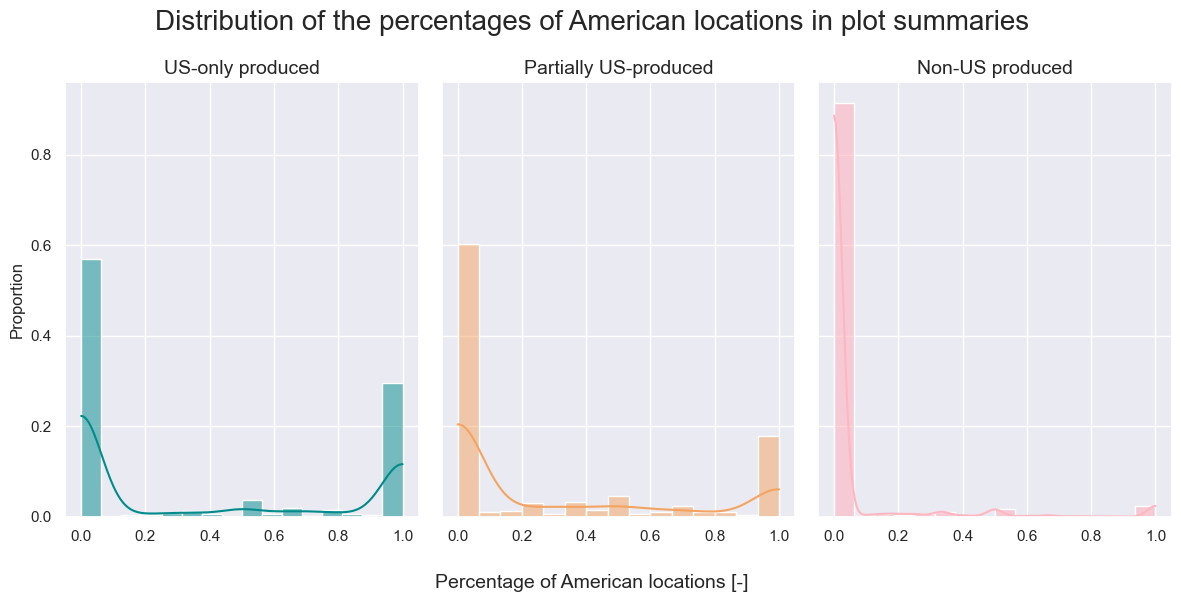

In [144]:
# First visualization

fig, axes = plt.subplots(1, 3, figsize = (12,6), sharey=True)
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
# bins = 'auto' produces too small bins if no log scale used
sns.histplot(df_GPE_us_only['Percentage_american_culture'], kde=True, stat='proportion', bins = 'auto', color='darkcyan', cumulative = False, log_scale= False, ax=axes[0]).set_title("US-only produced", fontsize=14)
axes[0].set(xlabel=None)
sns.histplot(df_GPE_partially_us['Percentage_american_culture'], kde=True, stat='proportion', bins = 'auto', color='sandybrown', cumulative = False, log_scale= False, ax=axes[1]).set_title("Partially US-produced", fontsize=14)
axes[1].set(xlabel=None)
sns.histplot(df_GPE_RoW['Percentage_american_culture'], kde=True, stat='proportion', bins = 'auto', color='lightpink', cumulative = False, log_scale= False, ax=axes[2], alpha = 0.6).set_title("Non-US produced", fontsize=14) 
axes[2].set(xlabel=None)
fig.suptitle("Distribution of the percentages of American locations in plot summaries", fontsize=20)
fig.supxlabel("Percentage of American locations [-]", fontsize=14)
fig.tight_layout()

plt.savefig('data/plots_website/summaries_distribution_GPE.png', dpi=300, bbox_inches='tight')
plt.show()

The distributions for US-only and for partially-US produced movies are bimodal. At first, one observes that more than 50% of all US-only produced movies don't contain any US locations in the plot summaries. But a substantial part of 30% of the US-only movies happen exclusively on US territory. As can be observed, the partially US produced movies follow the same pattern but with a slightly increased proportion of movies not happening on US territory, whereas the proportion of plot summaries decreases to 20%. The plot to the right shows, that 90% of all movies produced strictly outside the US don't talk about US geographic locations.

Timeseries of American culture using GPE

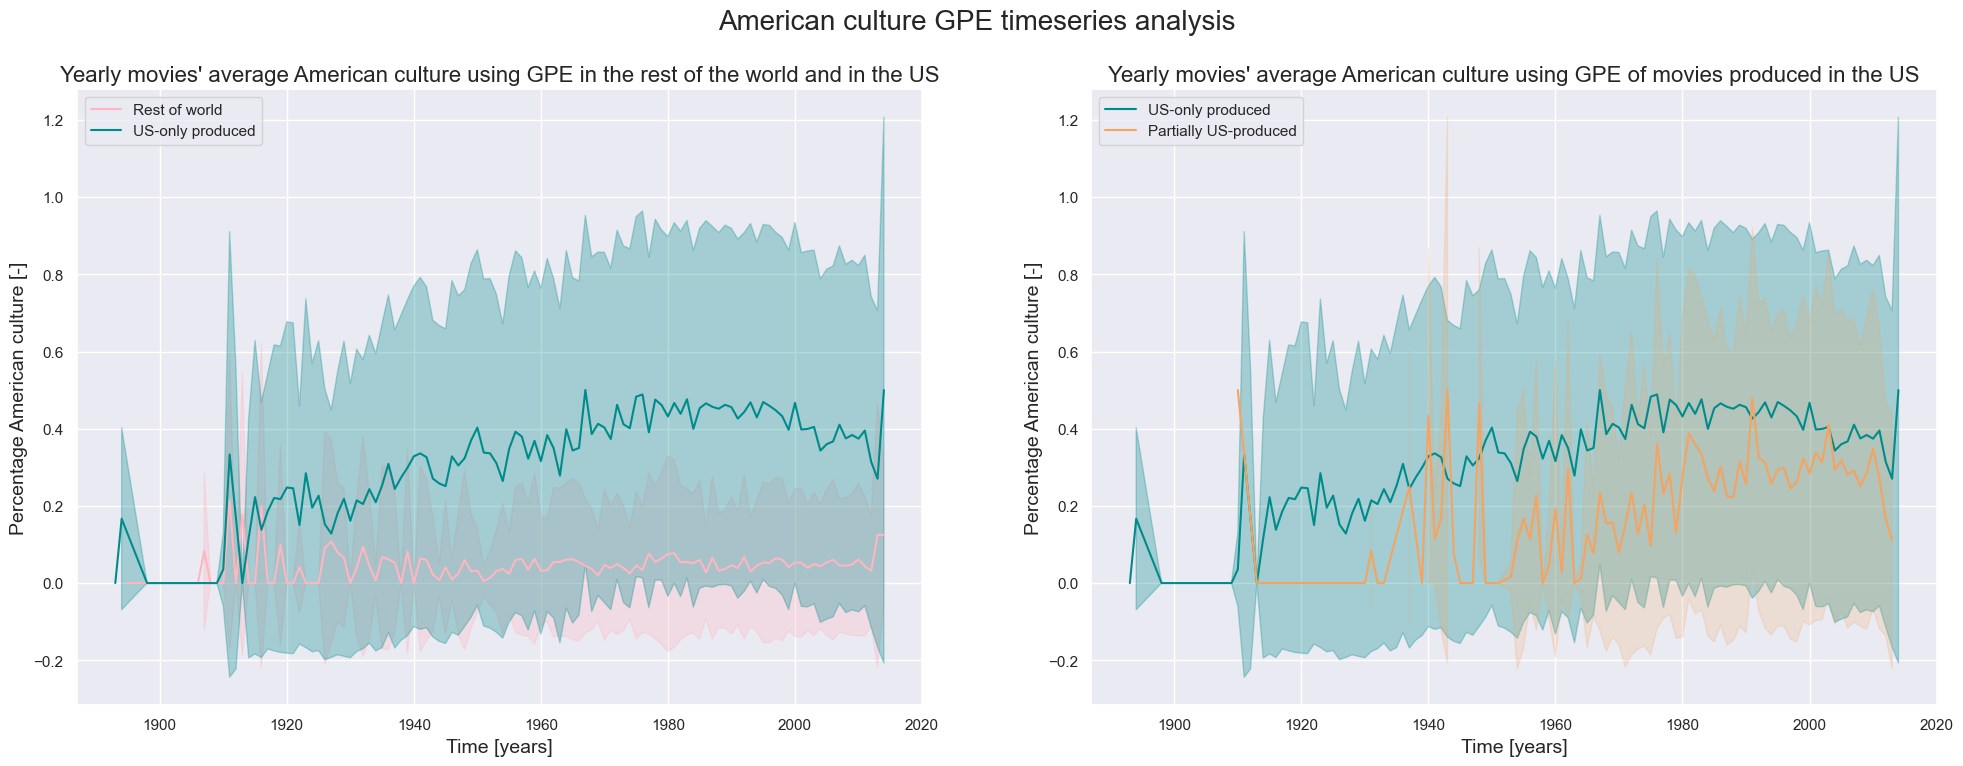

In [145]:
# time series of american culture using GPE

# average box office revenue for all movies per year world wide
avrg_ROW_USculture_per_year_GPE = df_GPE_RoW.groupby('release_year')['Percentage_american_culture'].mean()
std_ROW_USculture_per_year_GPE = df_GPE_RoW.groupby('release_year')['Percentage_american_culture'].std()

# average box office revenue for all movies per year in the US (movies STRICTLY produced in the US)
avrg_us_USculture_per_year_GPE = df_GPE_us_only.groupby('release_year')['Percentage_american_culture'].mean()
std_us_USculture_per_year_GPE = df_GPE_us_only.groupby('release_year')['Percentage_american_culture'].std()

# average box office revenue for all movies per year in the US (movies PARTIALLY produced in the US)
avrg_us_partial_USculture_per_year_GPE = df_GPE_partially_us.groupby('release_year')['Percentage_american_culture'].mean()
std_us_partial_USculture_per_year_GPE = df_GPE_partially_us.groupby('release_year')['Percentage_american_culture'].std()

fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize = (24,8))
# US-only produced vs ROW
ax[0].plot(df_GPE_RoW['release_year'].drop_duplicates().sort_values()[:-1], avrg_ROW_USculture_per_year_GPE, label = 'Rest of world', color = 'lightpink')
ax[0].fill_between(df_GPE_RoW['release_year'].drop_duplicates().sort_values()[:-1], y1= (avrg_ROW_USculture_per_year_GPE- std_ROW_USculture_per_year_GPE), y2 = (avrg_ROW_USculture_per_year_GPE+ std_ROW_USculture_per_year_GPE), linestyle='-', color='lightpink', alpha=0.3)
ax[0].plot(df_GPE_us_only['release_year'].drop_duplicates().sort_values()[:-1], avrg_us_USculture_per_year_GPE, label = 'US-only produced', color = 'darkcyan')
ax[0].fill_between(df_GPE_us_only['release_year'].drop_duplicates().sort_values()[:-1], y1= (avrg_us_USculture_per_year_GPE - std_us_USculture_per_year_GPE), y2 = (avrg_us_USculture_per_year_GPE+ std_us_USculture_per_year_GPE), linestyle='-', color='darkcyan', alpha=0.3)
ax[0].set_title("Yearly movies' average American culture using GPE in the rest of the world and in the US", fontsize = 16)
ax[0].set_xlabel("Time [years]", fontsize = 14)
ax[0].set_ylabel("Percentage American culture [-]", fontsize = 14)
ax[0].legend()

# US-only produced vs partially US-produced
ax[1].plot(df_GPE_us_only['release_year'].drop_duplicates().sort_values()[:-1], avrg_us_USculture_per_year_GPE, label = 'US-only produced', color = 'darkcyan')
ax[1].fill_between(df_GPE_us_only['release_year'].drop_duplicates().sort_values()[:-1], y1= (avrg_us_USculture_per_year_GPE - std_us_USculture_per_year_GPE), y2 = (avrg_us_USculture_per_year_GPE+ std_us_USculture_per_year_GPE), linestyle='-', color='darkcyan', alpha=0.3)
ax[1].plot(df_GPE_partially_us['release_year'].drop_duplicates().sort_values()[:-1], avrg_us_partial_USculture_per_year_GPE , label = 'Partially US-produced', color = 'sandybrown')
ax[1].fill_between(df_GPE_partially_us['release_year'].drop_duplicates().sort_values()[:-1], y1= (avrg_us_partial_USculture_per_year_GPE  - std_us_partial_USculture_per_year_GPE), y2 = (avrg_us_partial_USculture_per_year_GPE + std_us_partial_USculture_per_year_GPE ), linestyle='-', color='sandybrown', alpha=0.2)
ax[1].set_title("Yearly movies' average American culture using GPE of movies produced in the US", fontsize = 16)
ax[1].set_xlabel("Time [years]", fontsize = 14)
ax[1].set_ylabel("Percentage American culture [-]", fontsize = 14)
ax[1].legend()
fig.suptitle("American culture GPE timeseries analysis", fontsize = 20)
plt.savefig('data/plots_website/summeries_timeseries_GPE.png', dpi=300, bbox_inches='tight')
plt.show()

Starting with the left figure depicting the evolution of the average yearly percentage of American culture, one observes that for US-only produced movies this percentage tends to follow an increasing trend with an oscillation. On the contrary, the percentage of American culture for Non US-produced movies seems to stay roughly constant during the considered time span with values close to 5%.

Moving on to the right plot comparing the average yearly percentage of American culture between US-only and partially US-produced movies, one notes increasing trend with stronger oscillations for partially US-produced movies than for US-only produced movies.

Interestingly, the non US-produced movies don't follow the increasing use of American locations in the plot summaries. This observation speaks against the hypothesis that non US movies are influenced by American film industry and adapt their movies to plot summeries taking place on US territory. 

**CHECK IF THIS CORRESPONDS TO FILM D'AUTEURS**

Finally, these results must be interpreted with a critical perspective. As already mentioned, many movies in the dataset do not contain any GPE (Geopolitical Entities) because they are purely fictional works. For example, *Star Wars*, *The Lord of the Rings*, and *Hunger Games* feature only imaginary locations that the NLP pipeline cannot and should not recognize. This limitation tends to lower the calculated average percentage of American location references. Indeed, the mean is sensitive to outliers and overrepresented values. Additionally, movies with plots spanning both real and fictional locations may contain real existing locations although they play in fictional worlds. For instance, *Harry Potter* movies take place in the train station of London at the beginning but take place mostly in Hogwarts, a fictional place. A final limitation stems from the Geopy library itself. Some locations, such as Palestine, are incorrectly identified as being more likely in the US than in the Middle East ([Palestine, Texas, US](https://en.wikipedia.org/wiki/Palestine,_Texas)). Thus, while the Nominatim function of Geopy produces generally robust results, they are not entirely accurate.


**PARLER DE TRANSFORMERS CONTEXT POUR ACHEVAL FICTION SANS REALITé**

### B) Assessing the american culture in plot summaries using the crafted Amercian word lexicon
The goal is here to scan once again the plot summaries of US-only, partially US- and Non-US produced movies but this time with a handcrafted lexicon of words representing a realistic and typical sample of the american culture.

The American word lexicon is created using ChatGPT (see notebooks *NLP_P3.ipynb* and *American_vocab.ipynb*) ([Chat-GPT](https://chatgpt.com/)). The procedure is simple: one asks ChatGPT to generate a Python set of 200 words that are unique to the American culture and that truly represent it. Using ChatGPT in this case is relevant since it has been trained on the entire internet and thus has seen a tremendous amount of text resources about the United States such as review articles, Wikipedia pages, etc. To obtain a valuable list, one uses *ChatGPT 4o model* along with multiple list generations. The final list is taken as the intersection of all generated lists (NB: this directly implement online in the chat with ChatGPT and not in *American_vocab.ipynb*). Finally, to increase the granularity of the generated lexicon, one allows ChatGPT to generate multi-words expressions as for example, *slam dunk* or *white house*. All the words are written in lowercase to facilitate the integration of the set in *Spacy* NLP pipeline implmented in the *NLP_P3.ipynb* notebook.

However, one must keep in mind that generating "only" 200 words to create a lexicon representing American culture is not perfect and might not be enough to grasp the American culture. Indeed, adding more words will allow to better represent the American culture in the plot summaries. The choice of the number of words is then a trade-off between the running time of NLP scripts on the plot summaries and the targeted precision. A former studied approach was to scrap Wikipedia pages of the United States along with other Wikipedia country pages using built-in Python libraries. The concept was to retrieve the unique American words of the Wikipedia page by substracting the words appearing on the other countrys' Wikipedia pages, having removed the stop words before. This method was abondonned because of the huge number of irrelevant words retrieved by in this process. For example, if the word *table*, having nothing to do with American culture, was appearing in the United States' Wikipedia page but not in the pages of France, Canada and Germany, it was added to the lexicon. Furthermore, typical American words such as *hollywood*, *thanksgiving* and *cowboy* appeared in other Wikipedia pages, and were therefore removed from the lexicon during substraction what made those Widipedia pages unusable, unless these words would have been manually readded to the lexicon of American words. This explains the choice of using ChatGPT for the creation of the American lexicon.

Load the set of American words representing the lexicon created from Wikipedia data (see notebook *American_vocab.ipynb*) for more details.

In [146]:
with open('data/NLP_datasets/NLP_US_lexicon/unique_us_words_set.pkl', 'rb') as f:
    unique_us_words_set = pickle.load(f)

print(f"The lexicon of American words contains {len(unique_us_words_set)} words.")
print(f"The first 10 words of the lexicon are:\n {list(unique_us_words_set)[:10]}") # transform the us lexicon into a list to allow for indexing operation

The lexicon of American words contains 200 words.
The first 10 words of the lexicon are:
 ['mcdonalds', 'root beer', 'pumpkin pie', 'jefferson memorial', 'senator', 'president', 'hollywood', 'saloon', 'gold rush', 'cadillac']


#### 1) Processing the US-only produced movies

In [147]:
df_US_lexicon_us_only = pd.read_csv("data/NLP_datasets/NLP_US_lexicon/us_only_movies_NLP_US_lexicon.csv", sep=',') 

# Percentages of american culture using GPE
mean_american_culture_US_lexicon_us_only_movies = df_US_lexicon_us_only['Percentage_american_culture_lexicon'].mean()*100

# count the proportions of zeros
df_US_lexicon_us_only['Percentage_american_culture_lexicon'] = pd.to_numeric(df_US_lexicon_us_only['Percentage_american_culture_lexicon']).astype('float64')
proportion_0_percentage_us_only_US_lexicon = (len(df_US_lexicon_us_only[df_US_lexicon_us_only['Percentage_american_culture_lexicon'] == 0.0])/len(df_US_lexicon_us_only)*100)

print(f"The mean american culture percentage for Non-US produced movies using only GPE information is {mean_american_culture_US_lexicon_us_only_movies:.2f} %.")
print(f"The percentage of zero values on the Non US-produced GPE dataset is: {proportion_0_percentage_us_only_US_lexicon:.2f} %.")

df_US_lexicon_us_only.head(10)

The mean american culture percentage for Non-US produced movies using only GPE information is 0.59 %.
The percentage of zero values on the Non US-produced GPE dataset is: 63.84 %.


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,Total_tokens,Tokens_US_frequencies,Percentage_american_culture_lexicon
0,The Hunger Games,686533290.0,"Action,Adventure,Sci-Fi",2012.0,7.2,1022897.0,410,Counter({'president': 2}),0.004878
1,The Lemon Drop Kid,2300000.0,"Comedy,Crime,Music",1951.0,7.0,2303.0,438,Counter(),0.000000
2,Dark Water,49483352.0,"Drama,Horror,Mystery",2005.0,5.6,66164.0,375,Counter(),0.000000
3,Sing,2260616.0,"Drama,Musical",1989.0,6.7,974.0,296,"Counter({'diner': 3, 'high school': 1})",0.013514
4,Meet John Doe,NaN,"Comedy,Drama,Romance",1941.0,7.6,15255.0,290,"Counter({'baseball': 1, 'diner': 1})",0.006897
5,Husband for Hire,NaN,NaN,2008.0,NaN,NaN,182,Counter(),0.000000
6,Exodus,NaN,NaN,1960.0,NaN,NaN,409,Counter(),0.000000
7,House Party 2,19438638.0,"Comedy,Drama,Music",1991.0,5.3,7205.0,683,Counter({'campus': 5}),0.007321
8,Charlie Chan's Secret,NaN,NaN,1936.0,NaN,NaN,56,Counter(),0.000000
9,The Biggest Fan,NaN,NaN,2002.0,NaN,NaN,88,"Counter({'high school': 2, 'prom': 1})",0.034091


For US-only produced movies, a similar result as above is observed. In addition, the example of the dataframe presented above shows that the algorithm detects multi expression words. This is reassuring for the functioning of the process (see notebook *NLP_P3.ipynb*) and for a precise detection of typical American words.

#### 2) Processing the partially US-produced movies

In [148]:
df_US_lexicon_us_partially = pd.read_csv("data/NLP_datasets/NLP_US_lexicon/us_partially_movies_NLP_US_lexicon.csv", sep=',') 

# Percentages of american culture using GPE
mean_american_culture_US_lexicon_us_partially_movies = df_US_lexicon_us_partially ['Percentage_american_culture_lexicon'].mean()*100

# count the proportions of zeros
df_US_lexicon_us_partially['Percentage_american_culture_lexicon'] = pd.to_numeric(df_US_lexicon_us_partially['Percentage_american_culture_lexicon']).astype('float64')
proportion_0_percentage_us_partially_US_lexicon = (len(df_US_lexicon_us_partially [df_US_lexicon_us_partially['Percentage_american_culture_lexicon'] == 0.0])/len(df_US_lexicon_us_partially )*100)

print(f"The percentage of zero values on the Non US-produced GPE dataset is: {proportion_0_percentage_us_partially_US_lexicon:.2f} %.")
print(f"The mean american culture percentage for Non-US produced movies using only GPE information is {mean_american_culture_US_lexicon_us_partially_movies:.2f} %.")

df_US_lexicon_us_partially.head(10)

The percentage of zero values on the Non US-produced GPE dataset is: 63.85 %.
The mean american culture percentage for Non-US produced movies using only GPE information is 0.41 %.


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,Total_tokens,Tokens_US_frequencies,Percentage_american_culture_lexicon
0,A Cry in the Dark,6908797.0,NaN,1988.0,NaN,NaN,206,Counter({'barbecue': 1}),0.004854
1,End Game,NaN,"Action,Thriller",2006.0,5.1,5745.0,177,Counter({'president': 8}),0.045198
2,"Come Back, Africa",NaN,NaN,1960.0,NaN,NaN,206,Counter(),0.000000
3,Kehtaa Hai Dil Baar Baar,NaN,"Comedy,Drama,Romance",2002.0,4.7,204.0,86,Counter(),0.000000
4,Pieces,2032311.0,NaN,1982.0,NaN,NaN,295,"Counter({'skateboard': 1, 'campus': 1})",0.006780
5,The Good Life,NaN,"Comedy,Drama",2007.0,6.4,2352.0,24,Counter(),0.000000
6,Eastern Promises,17266000.0,NaN,2007.0,NaN,NaN,287,Counter(),0.000000
7,"Wait Until Spring, Bandini",NaN,Drama,1989.0,6.2,754.0,28,Counter(),0.000000
8,Sophie's Choice,30036000.0,"Drama,Romance",1982.0,7.5,53987.0,196,Counter(),0.000000
9,Until Death,NaN,"Action,Crime,Drama",2007.0,5.7,10503.0,325,Counter(),0.000000


One observes, that in the plot summaries the percentages of American words from the crafted word lexicon are very low. Here, the column *Total_tokens* contains the words of the plot summeries after having removed the stop words from them and after lematization using *spacy*. Despite the tokenization process of the plot summeries, the tokens are still numerous and the lexicon words rather rare which leads to low percentages.

#### 3) Processing the Non US-produced movies (RoW)

In [149]:
df_US_lexicon_RoW = pd.read_csv("data/NLP_datasets/NLP_US_lexicon/RoW_movies_NLP_US_lexicon.csv", sep=',') 

# Percentages of american culture using GPE
mean_american_culture_US_lexicon_RoW_movies = df_US_lexicon_RoW['Percentage_american_culture_lexicon'].mean()*100

# count the proportions of zeros
df_US_lexicon_RoW['Percentage_american_culture_lexicon'] = pd.to_numeric(df_US_lexicon_RoW['Percentage_american_culture_lexicon']).astype('float64')
proportion_0_percenatge_RoW_US_lexicon = (len(df_US_lexicon_RoW[df_US_lexicon_RoW['Percentage_american_culture_lexicon'] == 0.0])/len(df_US_lexicon_RoW)*100)

print(f"The mean american culture percentage for Non-US produced movies using only GPE information is {mean_american_culture_US_lexicon_RoW_movies:.2f} %.")
print(f"The percentage of zero values on the Non US-produced GPE dataset is: {proportion_0_percenatge_RoW_US_lexicon:.2f} %.")

df_US_lexicon_RoW.head(10)

The mean american culture percentage for Non-US produced movies using only GPE information is 0.25 %.
The percentage of zero values on the Non US-produced GPE dataset is: 82.79 %.


,title,box_office,genres_IMDB,release_year,averageRating,numVotes,Total_tokens,Tokens_US_frequencies,Percentage_american_culture_lexicon
0,Taxi Blues,NaN,NaN,1990.0,NaN,NaN,16,Counter(),0.000000
1,Narasimham,NaN,"Action,Drama",2000.0,7.6,2012.0,270,Counter({'supreme court': 1}),0.003704
2,Up and Down,2705163.0,NaN,2004.0,NaN,NaN,50,Counter(),0.000000
3,Ghost In The Noonday Sun,NaN,NaN,1973.0,NaN,NaN,32,Counter(),0.000000
4,Ashes to Ashes,NaN,Thriller,1999.0,7.1,23.0,217,Counter({'independence': 1}),0.004608
5,The Rats of Tobruk,NaN,"Action,Drama,War",1944.0,5.4,316.0,82,Counter(),0.000000
6,Nee Sneham,NaN,NaN,2002.0,NaN,NaN,212,Counter(),0.000000
7,Bhagwan Dada,NaN,NaN,1986.0,NaN,NaN,808,Counter({'pledge': 1}),0.001238
8,Mr. & Mrs. '55,NaN,"Comedy,Musical,Romance",1955.0,7.1,688.0,101,Counter({'freedom': 1}),0.009901
9,Amici miei,NaN,"Comedy,Drama",1975.0,7.9,8171.0,163,Counter(),0.000000


Same interpretation of the other two dataframes.

#### Basic statistical analysis of the three subdatasets used above for the American word lexicon

In [150]:
# american movies STRICTLY produced in the US
basic_stats_lexicon_US = df_US_lexicon_us_only['Percentage_american_culture_lexicon'].describe()*100
# american movies PARTIALLY produced in the US
basic_stats_lexicon_US_partial = df_US_lexicon_us_partially['Percentage_american_culture_lexicon'].describe()*100
# Rest of world (= Non Us movies)
basic_stats_lexicon_ROW = df_US_lexicon_RoW['Percentage_american_culture_lexicon'].describe()*100

dict_results_lexicon = {'US-only produced': [basic_stats_lexicon_US.loc['50%'], basic_stats_lexicon_US.loc['mean'], basic_stats_lexicon_US.loc['std'], basic_stats_lexicon_US.loc['max'], basic_stats_lexicon_US.loc['min']], 
                'Partially US-produced': [basic_stats_lexicon_US_partial.loc['50%'], basic_stats_lexicon_US_partial.loc['mean'], basic_stats_lexicon_US_partial.loc['std'], basic_stats_lexicon_US_partial.loc['max'], basic_stats_lexicon_US_partial.loc['min']],
                'Non US produced (ROW)': [basic_stats_lexicon_ROW.loc['50%'], basic_stats_lexicon_ROW.loc['mean'], basic_stats_lexicon_ROW.loc['std'], basic_stats_lexicon_ROW.loc['max'], basic_stats_lexicon_ROW.loc['min']]}

df_basic_stat_lexicon = pd.DataFrame(dict_results_lexicon, index = ['median [-]', 'mean [-]', 'std [-]', 'max [-]', 'min [-]'])

print(f"{100-proportion_0_percentage_us_only_US_lexicon:.2f}% of the US-only produced movies contain at least one word of the American word lexicon.")
print(f"{100-proportion_0_percentage_us_partially_US_lexicon:.2f}% of the Partially US produced movies contain at least one word of the American word lexicon.")
print(f"{100-proportion_0_percenatge_RoW_US_lexicon:.2f}% of the Non US produced movies (ROW) contain at least one word of the American word lexicon.")

df_basic_stat_lexicon.style.format("{:.2f}") # to display only 1 decimal after the comma taking advantage of the Jupyter notebook environment

36.16% of the US-only produced movies contain at least one word of the American word lexicon.
36.15% of the Partially US produced movies contain at least one word of the American word lexicon.
17.21% of the Non US produced movies (ROW) contain at least one word of the American word lexicon.


,US-only produced,Partially US-produced,Non US produced (ROW)
median [-],0.00,0.00,0.00
mean [-],0.59,0.41,0.25
std [-],1.30,0.95,0.85
max [-],20.00,12.50,15.00
min [-],0.00,0.00,0.00


Looking at the basic statistics on the percentages of American culture using the lexicon, one notices that the median is zero and for all production types which indicates that a lot of movies don't contain any of the 200 typical American words of the lexicon in their plot summaries. In fact, this was to be expected since a lot of movies talk of something else than American culture or American daily life. This can be explained by the fact that many movies in the dataset do talk about fictional cultures and therefroe the summary plot is simply not talking about American culture. For example, *Star Wars*, *The Lord of the Rings*, and *Hunger Games* feature only imaginary societies and do not contain the characteristic words. As visible from the percentages above, about 36% of Us-only and US-partially produced movies cointain at least one word of the American word lexicon. For Non US produced movies, this percentage is two times lower. Now, looking at the mean, it is lower than 1% for all movies for the reason explained above. 

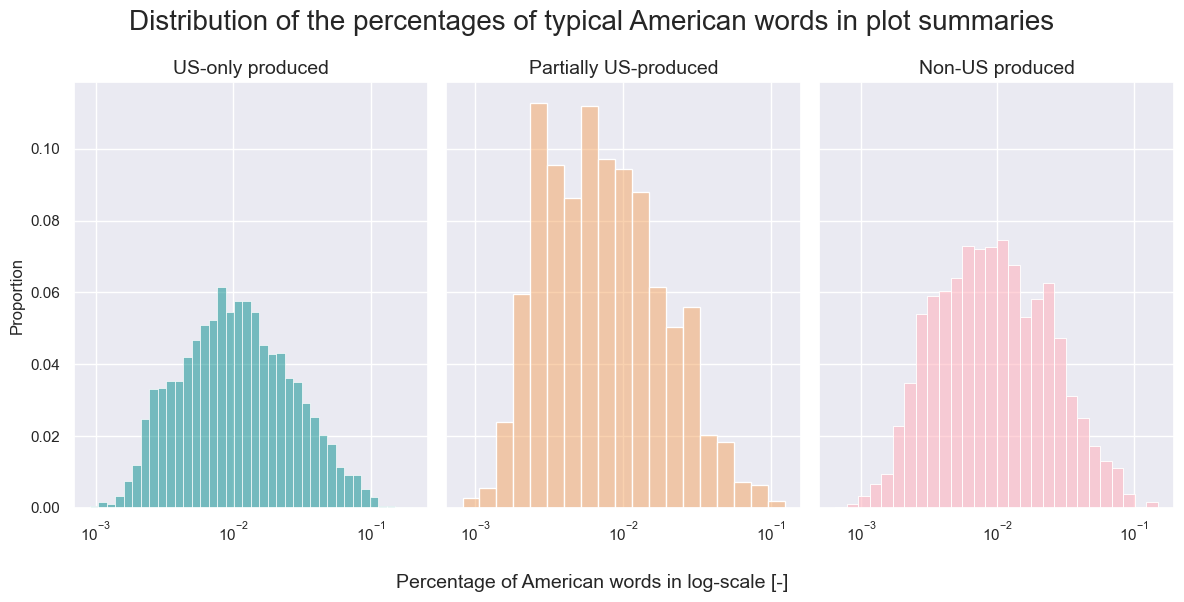

In [151]:
# First visualization

fig, axes = plt.subplots(1, 3, figsize = (12,6), sharey=True)
# stat = 'frequency' chosen since it represent the relative frequency (proportion) of movies in each bin, scaled to sum to 1.
# And it is useful for comparing distributions with different sample sizes
# bins = 'auto' produces too small bins if no log scale used
sns.histplot(df_US_lexicon_us_only['Percentage_american_culture_lexicon'], kde=True, stat='proportion', bins = 'auto', color='darkcyan', cumulative = False, log_scale= True, ax=axes[0]).set_title("US-only produced", fontsize=14)
axes[0].set(xlabel=None)
sns.histplot(df_US_lexicon_us_partially['Percentage_american_culture_lexicon'], kde=True, stat='proportion', bins = 'auto', color='sandybrown', cumulative = False, log_scale= True, ax=axes[1]).set_title("Partially US-produced", fontsize=14)
axes[1].set(xlabel=None)
sns.histplot(df_US_lexicon_RoW['Percentage_american_culture_lexicon'], kde=True, stat='proportion', bins = 'auto', color='lightpink', cumulative = False, log_scale= True, ax=axes[2], alpha = 0.6).set_title("Non-US produced", fontsize=14) 
axes[2].set(xlabel=None)
fig.suptitle("Distribution of the percentages of typical American words in plot summaries", fontsize=20)
fig.supxlabel("Percentage of American words in log-scale [-]", fontsize=14)
fig.tight_layout()

plt.savefig('data/plots_website/summaries_distribution_lexicon.png', dpi=300, bbox_inches='tight')
plt.show()

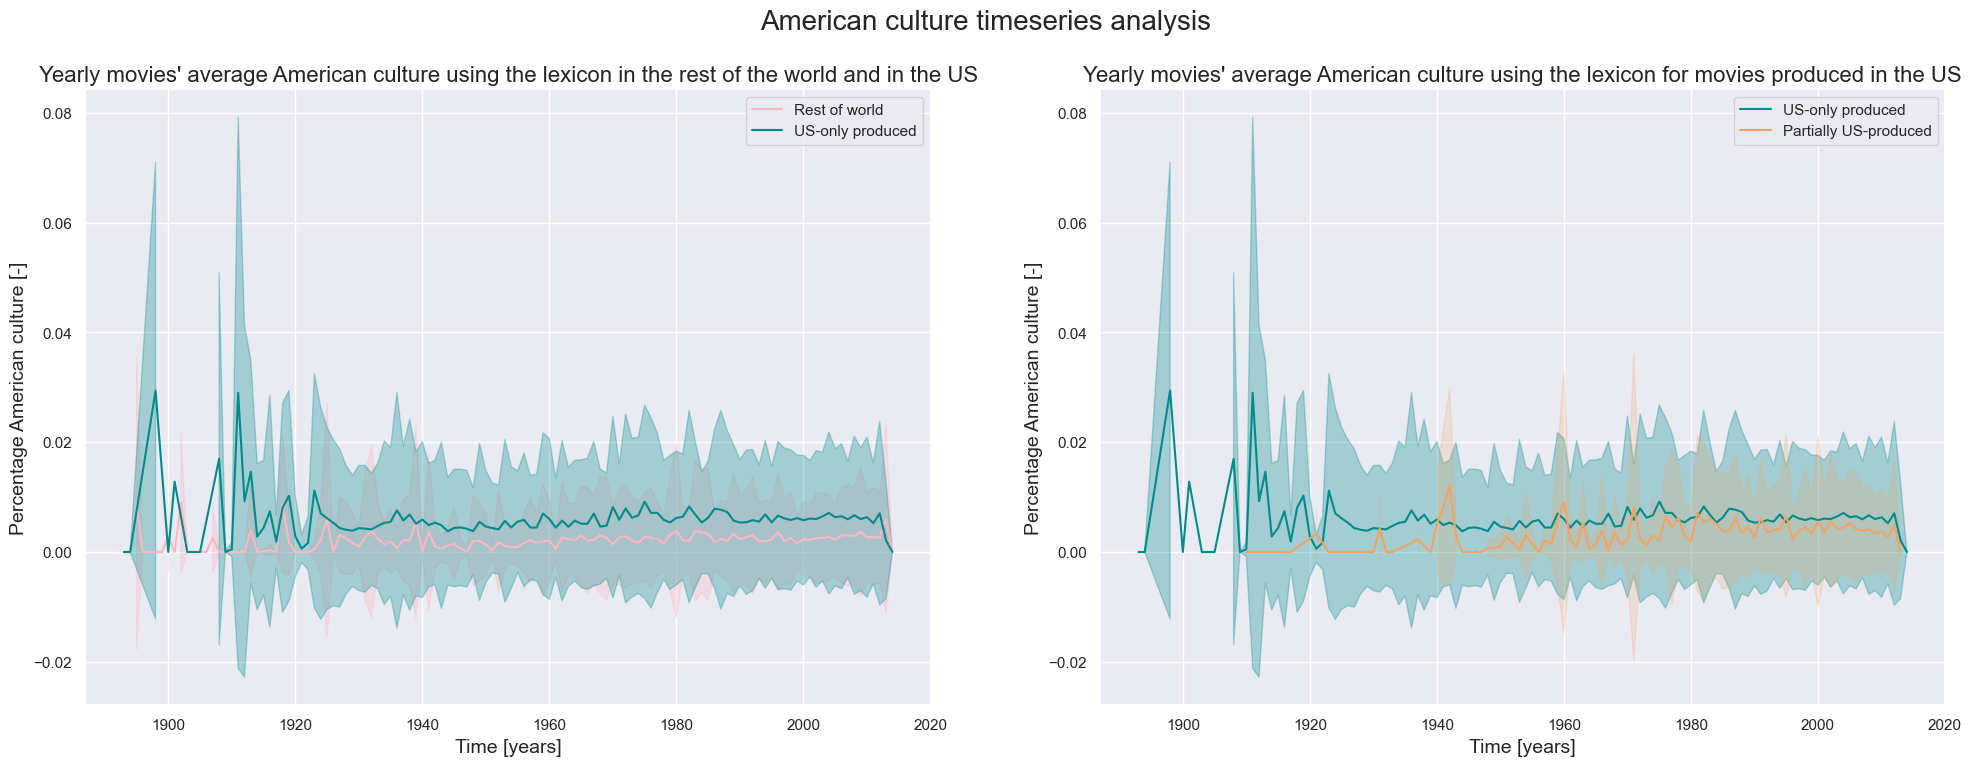

In [152]:
# time series of american culture using GPE

# average box office revenue for all movies per year world wide
avrg_ROW_USculture_per_year_lexcon = df_US_lexicon_RoW.groupby('release_year')['Percentage_american_culture_lexicon'].mean()
std_ROW_USculture_per_year_lexicon = df_US_lexicon_RoW.groupby('release_year')['Percentage_american_culture_lexicon'].std()

# average box office revenue for all movies per year in the US (movies STRICTLY produced in the US)
avrg_us_USculture_per_year_lexicon = df_US_lexicon_us_only.groupby('release_year')['Percentage_american_culture_lexicon'].mean()
std_us_USculture_per_year_lexicon = df_US_lexicon_us_only.groupby('release_year')['Percentage_american_culture_lexicon'].std()

# average box office revenue for all movies per year in the US (movies PARTIALLY produced in the US)
avrg_us_partial_USculture_per_year_lexicon = df_US_lexicon_us_partially.groupby('release_year')['Percentage_american_culture_lexicon'].mean()
std_us_partial_USculture_per_year_lexicon = df_US_lexicon_us_partially.groupby('release_year')['Percentage_american_culture_lexicon'].std()

fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize = (24,8))
# US-only produced vs ROW
ax[0].plot(df_US_lexicon_RoW['release_year'].drop_duplicates().sort_values()[:-1], avrg_ROW_USculture_per_year_lexcon, label = 'Rest of world', color = 'lightpink')
ax[0].fill_between(df_US_lexicon_RoW['release_year'].drop_duplicates().sort_values()[:-1], y1= (avrg_ROW_USculture_per_year_lexcon- std_ROW_USculture_per_year_lexicon), y2 = (avrg_ROW_USculture_per_year_lexcon+ std_ROW_USculture_per_year_lexicon), linestyle='-', color='lightpink', alpha=0.3)
ax[0].plot(df_US_lexicon_us_only['release_year'].drop_duplicates().sort_values()[:-1], avrg_us_USculture_per_year_lexicon, label = 'US-only produced', color = 'darkcyan')
ax[0].fill_between(df_US_lexicon_us_only['release_year'].drop_duplicates().sort_values()[:-1], y1= (avrg_us_USculture_per_year_lexicon - std_us_USculture_per_year_lexicon), y2 = (avrg_us_USculture_per_year_lexicon+ std_us_USculture_per_year_lexicon), linestyle='-', color='darkcyan', alpha=0.3)
ax[0].set_title("Yearly movies' average American culture using the lexicon in the rest of the world and in the US", fontsize = 16)
ax[0].set_xlabel("Time [years]", fontsize = 14)
ax[0].set_ylabel("Percentage American culture [-]", fontsize = 14)
ax[0].legend()

# US-only produced vs partially US-produced
ax[1].plot(df_US_lexicon_us_only['release_year'].drop_duplicates().sort_values()[:-1], avrg_us_USculture_per_year_lexicon, label = 'US-only produced', color = 'darkcyan')
ax[1].fill_between(df_US_lexicon_us_only['release_year'].drop_duplicates().sort_values()[:-1], y1= (avrg_us_USculture_per_year_lexicon - std_us_USculture_per_year_lexicon), y2 = (avrg_us_USculture_per_year_lexicon+ std_us_USculture_per_year_lexicon), linestyle='-', color='darkcyan', alpha=0.3)
ax[1].plot(df_US_lexicon_us_partially['release_year'].drop_duplicates().sort_values()[:-1], avrg_us_partial_USculture_per_year_lexicon , label = 'Partially US-produced', color = 'sandybrown')
ax[1].fill_between(df_US_lexicon_us_partially['release_year'].drop_duplicates().sort_values()[:-1], y1= (avrg_us_partial_USculture_per_year_lexicon  - std_us_partial_USculture_per_year_lexicon), y2 = (avrg_us_partial_USculture_per_year_lexicon + std_us_partial_USculture_per_year_lexicon ), linestyle='-', color='sandybrown', alpha=0.2)
ax[1].set_title("Yearly movies' average American culture using the lexicon for movies produced in the US", fontsize = 16)
ax[1].set_xlabel("Time [years]", fontsize = 14)
ax[1].set_ylabel("Percentage American culture [-]", fontsize = 14)
ax[1].legend()
fig.suptitle("American culture timeseries analysis", fontsize = 20)
plt.savefig('data/plots_website/summaries_timeseries_lexicon.png', dpi=300, bbox_inches='tight')
plt.show()

**A interpréter**

#### Comparison of the two NLP methods: GPE vs US lexicon

In [153]:


# Dataframe summarizing the findings.

dict_NLP_american_culture = {'US-only produced movies': [df_basic_GPE_office.iloc[1,0], df_basic_stat_lexicon.iloc[1,0]], 
                   'Partially US-produced movies': [df_basic_GPE_office.iloc[2,0], df_basic_stat_lexicon.iloc[1,1]], 
                   'Non US-produced movies': [df_basic_GPE_office.iloc[3,0], df_basic_stat_lexicon.iloc[1,2]] 
                   }

index_names = ["GPE", "US lexicon"]

df_summary_NLP_results = pd.DataFrame(dict_NLP_american_culture, index = index_names)
df_summary_NLP_results.index.name = "Method"

print("The below dataset shows the mean percentage of American culture for the tow implemented methods.")
df_summary_NLP_results.style.format("{:.2f}") # to display only 2 decimals after the comma taking advantage of the Jupyter notebook environment

The below dataset shows the mean percentage of American culture for the tow implemented methods.


,US-only produced movies,Partially US-produced movies,Non US-produced movies
Method,,,
GPE,36.72,45.23,100.00
US lexicon,0.59,0.41,0.25
